# Интеллектуальный анализ данных – весна 2024
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [1]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw06_texts/tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
4579,9358,54310,"Florida, USA",19-03-2020,"Officials say ""stay out of groups of 10""\r\r\n...",Negative
19142,27093,72045,#maga & read:,25-03-2020,#ccot #tcot #pjnet #teaparty #hannity #tucker ...,Negative
29710,40280,85232,"Lynnwood, WA",09-04-2020,Where am I going?\r\r\nA) to the grocery store...,Negative
6716,11964,56916,Texas,19-03-2020,@stacieco13 @CBSNews COVID-19 infecting entire...,Extremely Negative


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная эмоциональная окраска и 0 - если отрицательная.

In [3]:
df.Sentiment.value_counts()

Positive              11422
Negative               9917
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

In [4]:
df.Sentiment = df.Sentiment.str.contains('Positive').astype(int)

In [5]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,1
1,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,1
2,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,1
3,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",0
4,3804,48756,"ÃÂT: 36.319708,-82.363649",16-03-2020,As news of the regionÃÂs first confirmed COV...,1


Сбалансированы ли классы?

In [6]:
df.Sentiment.value_counts(normalize = True)

1    0.539589
0    0.460411
Name: Sentiment, dtype: float64

**Ответ:** Да, можно считать что более-менее

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [7]:
df.isnull().sum()

UserName            0
ScreenName          0
Location         7049
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

Заполняем пропуски

---

In [8]:
df.Location.fillna('Unknown', inplace = True)

In [9]:
(df.Location == 'Unknown').sum() #  у нас ранее было 3 Unknown, потом добавилось еще 7049

7052

Разделите данные на обучающие и тестовые в соотношении 7 : 3 и `random_state=0`

In [10]:
from sklearn.model_selection import train_test_split
# модуль model_selection содежит массу методов для настройки гиперпараметров, кросс-валидации и тд

In [11]:
train, test = train_test_split(df, test_size = 0.3, random_state=0)
train.shape, test.shape

((23410, 6), (10034, 6))

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведение токенов в нижний регистр

In [12]:
lower_text = (' '.join(train.OriginalTweet.tolist())).lower()
lower_text.islower()

True

In [13]:
split_text = np.array(lower_text.split())
unique_words, counts = np.unique(split_text, return_counts=True) # подсчитываем колличество встречаемых
my_dict = dict(zip(unique_words, counts)) # создаем словарь

Какой размер словаря получился?

In [14]:
len(unique_words)

79755

Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе

In [15]:
my_dict = dict(sorted(my_dict.items(), key=lambda item: item[1])[::-1])

In [16]:
list(my_dict.items())[:10]

[('the', 26815),
 ('to', 23373),
 ('and', 14684),
 ('of', 13012),
 ('a', 11737),
 ('in', 11198),
 ('for', 8566),
 ('#coronavirus', 8223),
 ('is', 7383),
 ('are', 7050)]

**Ответ:** здесь представлены постоянно используемые союзы (and), предлоги (to, of, in， for),  артикли (the, a), так же по хэштегу можем понять, что активно обсуждалось в твиттере в период, когда парсились комментарии

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [17]:
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /Users/syuy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
noise = np.array(stopwords.words('english'))
noise.shape, noise[:10] # здесь просто пример мусорных слов

((179,),
 array(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
        "you're"], dtype='<U10'))

In [19]:
for key in noise: # удаляем все стоп-слова из нашего словаря
    my_dict.pop(key, None)

In [20]:
list(my_dict.items())[:10] # top-10 самых популярных

[('#coronavirus', 8223),
 ('prices', 3891),
 ('food', 3820),
 ('grocery', 3469),
 ('supermarket', 3288),
 ('people', 3175),
 ('covid-19', 3173),
 ('store', 3155),
 ('#covid19', 2471),
 ('&amp;', 2314)]

In [21]:
len(my_dict)

79584

**Ответ:**  79755 (длина до удаления слов) -  79584 = 171 мусорное словечко выкинули. Топ слов обновился, появились уже слова а не союзы/предлоги/частицы, все мелкое и смысла не имеющее в отдельности было заменено словами на тематику пандемии

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [22]:
list(my_dict.items())[-20:] # top-20 самых редких

[('"#pricegouging"', 1),
 ('"#grocery', 1),
 ('"#food', 1),
 ('"#energy', 1),
 ('"#covid_19', 1),
 ('"#covid19', 1),
 ('"#coronavirus:', 1),
 ('"#contagion".', 1),
 ('"#bitcoin', 1),
 ('"#alcohol', 1),
 ('!social', 1),
 ('!@#@!@#', 1),
 ('!?', 1),
 ('!,', 1),
 ('!).', 1),
 ('!#somegoodnews', 1),
 ('!!!???', 1),
 ('!!!!!?????', 1),
 ('!!!!!!!!', 1),
 ('!!!!!!', 1)]

**Ответ:** много комбинаций из однотипных знаков пунктуации - можем ее в целом выкинуть, это только тональная окраска, не имеет смысла при анализе содержания текста. Так же много плохо обрезанных хештегов (к ним прилипли кавычки, собачки и тд.) - надо использовать более продвинутый токенайзер, чем сплит по пробелам, тогда эти хештеги получится привести в нормальный вид, это довольно популярные слова, поэтому у них вероятней всего есть "хорошо обработанные" близнецы-токены, просто объединим родственников - словарь уменьшится.


Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [23]:
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer

In [24]:
tw = TweetTokenizer()
unique_words_tw, counts_tw = np.unique(tw.tokenize(lower_text), return_counts=True) 
# считаем количество повторов каждого токена с помощью  return_counts=True
my_dict_tw = dict(zip(unique_words_tw, counts_tw))
# создаем словарик ключ - количество выше

In [25]:
my_dict_tw = dict(sorted(my_dict_tw.items(), key = lambda item:item[1], reverse = True)) # сортирую по убыванию

In [26]:
list(my_dict_tw.items())[:10] # топ-10 фаворитов по версии токенайзера TweetTokenizer

[('the', 26993),
 ('.', 24108),
 ('to', 23478),
 (',', 17571),
 ('and', 14825),
 ('of', 13044),
 ('a', 11891),
 ('in', 11348),
 ('?', 9524),
 ('#coronavirus', 8808)]

In [27]:
len(my_dict_tw)

58348

**Ответ:** TweetTokenizer может выделять знаки препинания на отдельные токены, поэтому запятые и точки у нас в топе повторов. Ситуация очень похожа на токенизацию путем сплита по пробелу, так же много неинформативных частиц и предлогов.

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [28]:
from string import punctuation

In [29]:
noise_tw = np.concatenate([np.array(list(punctuation)),noise]) # объединила знаки препинания и мусорые слова
noise_tw[:15]

array(['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-',
       '.', '/'], dtype='<U10')

In [30]:
for key in noise_tw:
  my_dict_tw.pop(key, None)

In [31]:
len(my_dict_tw) 

58145

In [32]:
list(my_dict_tw.items())[:10]

[('#coronavirus', 8808),
 ('â', 7415),
 ('\x82', 7311),
 ('19', 7167),
 ('covid', 6253),
 ('prices', 4601),
 ('\x92', 4372),
 ('food', 4367),
 ('store', 3877),
 ('supermarket', 3805)]

**Ответ:** все выглядит очень прилично за исключением раздробленных на части ссылок (('\x92', 4372), ('â', 7415)), эти части могут находиться в ссылках на источники с нестандартной кодировкой. TweetTokenizer отдельно считает эти части, хотя смысла содержательного в них нет. Сначала убрать все ссылки, а потом применять токейназер.

Удалите из словаря токены из одного символа, с позицией в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [33]:
my_dict_tw= dict(filter(lambda item: len(item[0])>1 or ord(item[0])<128, my_dict_tw.items()))
# применяем фильтр: односимвольные с позицией ord(x) >= 128 не пройдут!

In [34]:
list(my_dict_tw.items())[:10]

[('#coronavirus', 8808),
 ('19', 7167),
 ('covid', 6253),
 ('prices', 4601),
 ('food', 4367),
 ('store', 3877),
 ('supermarket', 3805),
 ('grocery', 3523),
 ('people', 3463),
 ('#covid19', 2589)]

In [35]:
list(my_dict_tw.items())[-20:]

[('zooming', 1),
 ('zoopla', 1),
 ('zorb', 1),
 ('zororo', 1),
 ('zouzou', 1),
 ('zp', 1),
 ('zu', 1),
 ('zuckerberg', 1),
 ('zumba', 1),
 ('zumbuehl', 1),
 ('zumindest', 1),
 ("zuppardo's", 1),
 ('zur', 1),
 ('zuschlã', 1),
 ('zusendung', 1),
 ('zwd', 1),
 ('zwoferink', 1),
 ('zzz', 1),
 ('zã', 1),
 ('âºper', 1)]

**Ответ:** Спец токенизация для твитов после всех обработок кажется лучше, мы просто еще и пунктуацию убрали. В сплите по пробелам убирали только стоп слова 

Выведите топ-10 популярных хештегов с количеством встреч. Что можно сказать о них?

In [36]:
top_hashtags = dict(filter(lambda item: item[0].startswith('#'), my_dict_tw.items()))
sorted(top_hashtags.items(), key = lambda item:item[1], reverse=True)[:10]

[('#coronavirus', 8808),
 ('#covid19', 2589),
 ('#covid_19', 1734),
 ('#covid2019', 946),
 ('#toiletpaper', 744),
 ('#covid', 641),
 ('#socialdistancing', 465),
 ('#coronacrisis', 448),
 ('#pandemic', 257),
 ('#coronaviruspandemic', 249)]

**Ответ:** по видимому, люди были сильно обеспокоены темой короновируса

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [37]:
top_links = dict(filter(lambda item: item[0].startswith('https://t.co'), my_dict_tw.items()))
sorted(top_links.items(), key = lambda item: item[1], reverse = True)[:10]

[('https://t.co/oxa7swtond', 5),
 ('https://t.co/gp3eusapl8', 4),
 ('https://t.co/3gbbdpdjat', 3),
 ('https://t.co/aziqcdgrnn', 3),
 ('https://t.co/bylqxrjmnt', 3),
 ('https://t.co/catkegayoy', 3),
 ('https://t.co/deftrui1pfã\x82â', 3),
 ('https://t.co/e2znxajpre', 3),
 ('https://t.co/g63rp042ho', 3),
 ('https://t.co/kuwipf1kqw', 3)]

**Ответ:** хэштеги чаще используемая история, чем ссылки на конкретные посты - людям не нравится совершать дополнительные действия по поиску нужной страницы, копированию ссылок и тд. Проще поставить хэштег, это норм способ повысить просмотры на посте, поэтому как в предыдущем пункте видим, что топ 10 встречаются достаточно большее количество раз, чем топ 10 по ссылкам

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для изначального выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co



In [38]:
# так же удалены ссылки на твиты
def custom_tokenizer(text):
  text = text.lower()
  tw = TweetTokenizer()
  tokens = tw.tokenize(text)
  tokens = list(filter(lambda item: (len(item)>1 or ord(item)<128) and (item not in noise_tw) and not item.startswith('https://t.co'), tokens))
  return tokens

In [39]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [40]:
from sklearn.feature_extraction.text import CountVectorizer

cnt_vec = CountVectorizer(tokenizer = custom_tokenizer) # создаем объект CountVectorizer с кастомным токенйзером
train_tokenized = cnt_vec.fit_transform(train.OriginalTweet) 

/Users/syuy/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [41]:
train_tokenized.shape

(23410, 45308)

**Ответ:** Размеры словаря из начала задания 2: 79755 - это простой сплит по пробелам. После этого была проведена работа по обработке нужных/ненужных токенов в функции custom_tokenizer. После применения custom_tokenizer осталось 45308 токенов.

Посмотрим на какой-нибудь конкретный твитт:

In [42]:
ind = 9023 # дано по условию
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment'] 

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 0)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [43]:
line = train.iloc[ind]['OriginalTweet'] # выделяю только текстовую часть
line

'Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs'

In [44]:
line_cnt_vec = cnt_vec.transform([line])
token_counts = line_cnt_vec.toarray()[0]
cnt_vec.get_feature_names_out()[token_counts.nonzero()]

array(['#coronavirusoutbreak', '#covid2019', '@skynews', 'brainless',
       'ffs', 'food', 'france', 'lets', 'nice', 'one', 'panic', 'ppl',
       'queueing', 'show'], dtype=object)

In [45]:
token_counts[token_counts.nonzero()]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

**Ответ:** Все одинаковые по важности, никто не выделяется, все токены встретились по одному разу

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [47]:
tfidf_vec = TfidfVectorizer(tokenizer = custom_tokenizer)
train_tokenized_tw = tfidf_vec.fit_transform(train.OriginalTweet)
line_tfidf = tfidf_vec.transform([line])

In [48]:
token_counts_2 = line_tfidf.toarray()[0]
token_names = tfidf_vec.get_feature_names_out()[token_counts_2.nonzero()]
token_names

array(['#coronavirusoutbreak', '#covid2019', '@skynews', 'brainless',
       'ffs', 'food', 'france', 'lets', 'nice', 'one', 'panic', 'ppl',
       'queueing', 'show'], dtype=object)

In [49]:
token_weights = token_counts_2[token_counts.nonzero()]
token_weights

array([0.22584265, 0.16825193, 0.31042634, 0.38676412, 0.32447418,
       0.11328893, 0.32047314, 0.3012107 , 0.25427292, 0.16306723,
       0.1475947 , 0.25500646, 0.35434556, 0.24406492])

In [50]:
train_tokenized_tw.shape

(23410, 45308)

In [51]:
print(f'Слово с наименьшим весом: {token_names[np.argmin(token_weights)]}, вес - {min(token_weights)}')
print(f'Слово с наименьшим весом: {token_names[np.argmax(token_weights)]}, вес - {max(token_weights)}')

Слово с наименьшим весом: food, вес - 0.11328893069250721
Слово с наименьшим весом: brainless, вес - 0.3867641170466375


**Ответ:** у часто встречаемых токенов - меньший вес, если вспоминать, то люди действительно были обеспокоены трудностями с походом за продуктами и нехваткой гречки... Это часто обсуждалось в сети

brainless - встречалось реже, его применимость менее широкая чем у слова food

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [52]:
train.OriginalTweet = train.OriginalTweet.str.lower()
# сделала нижний регистр для комментариев

In [53]:
synonyms = np.array([
    "excellent",
    "great",
    "fine",
    "wonderful",
    "superb",
    "terrific",
    "awesome",
    "fantastic",
    "outstanding",
    "positive"
])

In [54]:
for i in synonyms:
    cnt = train[train['OriginalTweet'].apply(lambda x: i in x) & (train['Sentiment'] == 1)].shape[0]
    print(f'{i} = {cnt}')

  # ищем количество повторов для каждого слова синонима

excellent = 26
great = 466
fine = 67
wonderful = 20
superb = 6
terrific = 3
awesome = 32
fantastic = 10
outstanding = 6
positive = 214


In [55]:
word = 'fantastic'
positive_tweets = train[train['OriginalTweet'].apply(lambda x: word in x) & (train['Sentiment'] == 1)]
print(f'Размерность таблицы для слова: {word} = {positive_tweets.shape}')
positive_tweets.head()

Размерность таблицы для слова: fantastic = (10, 6)


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
9322,15113,60065,"Toronto, Ontario",20-03-2020,for all the grocery store workers during this ...,1
7864,13356,58308,UK,20-03-2020,fantastic scheme for artists and even better f...,1
24712,34041,78993,"Sanibel, FL",06-04-2020,check out our on over amp items at fantastic p...,1
24489,33756,78708,"Chicago, IL",06-04-2020,thanks @aldiusa for the fantastic online shopp...,1
2631,6980,51932,Unknown,18-03-2020,@thesun the panic buying will continue for wee...,1


Выбираю рандомно индекс твита, пусть это будет самая первая строка под номером 9322

In [56]:
positive_tweet_9322 = positive_tweets.loc[9322].OriginalTweet
positive_tweet_9322

'for all the grocery store workers during this time .. thank you ? ...also a great time to ask for a minimum wage increase for your fantastic work ? #coronacrisis #onpoli'

In [57]:
positive_tweet__tfidf = tfidf_vec.transform([positive_tweet_9322]) # применяем обученный ранее векторайзер

In [58]:
token_counts_3 = positive_tweet__tfidf.toarray()[0]
token_names = tfidf_vec.get_feature_names_out()[token_counts_3.nonzero()] # достаем наши токены
token_names

array(['#coronacrisis', '#onpoli', '..', '...', 'also', 'ask',
       'fantastic', 'great', 'grocery', 'increase', 'minimum', 'store',
       'thank', 'time', 'wage', 'work', 'workers'], dtype=object)

In [59]:
token_weights = token_counts_3[token_counts_3.nonzero()]
token_weights

array([0.20981663, 0.38022766, 0.22459351, 0.16461905, 0.19347848,
       0.26122944, 0.36306252, 0.21234771, 0.12441615, 0.21825944,
       0.29025633, 0.12072314, 0.1999188 , 0.32630056, 0.28840197,
       0.18118735, 0.16400619])

In [60]:
word = 'fantastic'
print(f'Слово {word}, вес - {token_weights[token_names == word]}')

Слово fantastic, вес - [0.36306252]


**Ответ:** гпт составил список из слов, которые могут быть в положительных твитах, опытным путем было выбрано слово fantastic, оно встречается всего в 10 положительных твитах, tfidf векторайзер считает слово достаточно важным, в строке 9322 у него вес 0.36306252.

Прилагательные из списка synonyms, которые встречались реже (чем 10 раз), как правило обладалили достаточно небольшим весом, видимо tfidf считал, что настолько редкие слова могут быть просто ошибочно написанными собратьями других слов и давал им малый вес, так как они почти не использовались

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [61]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Sentiment'], axis = 1), df['Sentiment'], test_size = 0.3, random_state=0)

In [62]:
bow_test = cnt_vec.transform(X_test.OriginalTweet) # Count Vectorizer
bow_test

<10034x45308 sparse matrix of type '<class 'numpy.int64'>'
	with 177991 stored elements in Compressed Sparse Row format>

In [63]:
bow_test_tfidf = tfidf_vec.transform(X_test.OriginalTweet) # Tfidf Vectorizer
bow_test_tfidf

<10034x45308 sparse matrix of type '<class 'numpy.float64'>'
	with 177991 stored elements in Compressed Sparse Row format>

Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, roc_auc_score


clf = LogisticRegression(max_iter=200, random_state=0) # Count Vectorizer
clf.fit(train_tokenized,y_train)
pred = clf.predict(bow_test)

In [65]:
accuracy_1_cv = (y_test == pred).mean() # зафиксирую, чтобы потом сравнивать
print(f'Accuracy Count Vectorizer: {accuracy_1_cv}')

Accuracy Count Vectorizer: 0.8673510065776361


In [66]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.86      0.85      0.85      4552
           1       0.87      0.89      0.88      5482

    accuracy                           0.87     10034
   macro avg       0.87      0.87      0.87     10034
weighted avg       0.87      0.87      0.87     10034



In [67]:
clf_2 = LogisticRegression(max_iter=200, random_state=0) # Tfidf Vectorizer
clf_2.fit(train_tokenized_tw,y_train)
pred_2 = clf_2.predict(bow_test_tfidf)

In [68]:
print(classification_report(y_test, pred_2))

              precision    recall  f1-score   support

           0       0.85      0.82      0.83      4552
           1       0.85      0.88      0.87      5482

    accuracy                           0.85     10034
   macro avg       0.85      0.85      0.85     10034
weighted avg       0.85      0.85      0.85     10034



In [69]:
accuracy_2_tfidf = (y_test == pred_2).mean()# accuracy
print(f'Accuracy Tfidf: {accuracy_2_tfidf}')

Accuracy Tfidf: 0.8534981064381104


**Ответ:** Accuracy больше у обычного Count Vectorizer, примерно на 0.014% окруленно. По видимому, при данном разбинии датасета лучше работает только подсчет частоты встречаемости слова в документе, а не учет его важность в контексте (как в tfidf).

In [70]:
print(f'Accuracy разница: {accuracy_1_cv - accuracy_2_tfidf}')

Accuracy разница: 0.01385290013952567


## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [71]:
from nltk.stem.snowball import SnowballStemmer

In [72]:
def custom_stem_tokenizer(text):
  tokens = custom_tokenizer(text)
  stemmer = SnowballStemmer('english')
  tokens = [stemmer.stem(w) for w in tokens]
  return tokens

In [73]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [74]:
cv = CountVectorizer(tokenizer = custom_stem_tokenizer) # Count Vectorizer
train_tokenized_2 = cv.fit_transform(train.OriginalTweet)

/Users/syuy/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [75]:
train_tokenized_2.shape

(23410, 36652)

In [76]:
tv = TfidfVectorizer(tokenizer = custom_stem_tokenizer) # Tfidf Vectorizer
train_tokenized_3 = tv.fit_transform(train.OriginalTweet)

In [77]:
train_tokenized_3.shape

(23410, 36652)

**Ответ:** размер словаря уменьшился, так как отбросили окончания и суффиксы слов и привели к общему корню

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [78]:
bow_test_2 = cv.transform(X_test.OriginalTweet) # Count Vectorizer
bow_test_2

<10034x36652 sparse matrix of type '<class 'numpy.int64'>'
	with 177963 stored elements in Compressed Sparse Row format>

In [79]:
bow_test_tfidf_2 = tv.transform(X_test.OriginalTweet) # Tfidf Vectorizer
bow_test_tfidf_2

<10034x36652 sparse matrix of type '<class 'numpy.float64'>'
	with 177963 stored elements in Compressed Sparse Row format>

In [80]:
clf_3= LogisticRegression(max_iter=200, random_state=0) # Count Vectorizer
bow_test_2
clf_3.fit(train_tokenized_2,y_train)
pred_3 = clf_3.predict(bow_test_2)
pred_3

array([1, 0, 1, ..., 0, 1, 1])

In [81]:
print(classification_report(y_test, pred_3))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      4552
           1       0.87      0.89      0.88      5482

    accuracy                           0.87     10034
   macro avg       0.87      0.86      0.87     10034
weighted avg       0.87      0.87      0.87     10034



In [82]:
accuracy_3_cv = (y_test == pred_3).mean() # accuracy
print(f'Accuracy после стемминга Count Vectorizer: {accuracy_3_cv}')

Accuracy после стемминга Count Vectorizer: 0.8669523619693044


In [83]:
clf_4 = LogisticRegression(max_iter = 200, random_state = 0) # Tfidf векторайзер 
clf_4.fit(train_tokenized_3,y_train)
pred_4 = clf_4.predict(bow_test_tfidf_2)
pred_4

array([1, 0, 1, ..., 0, 1, 1])

In [84]:
print(classification_report(y_test, pred_4))

              precision    recall  f1-score   support

           0       0.86      0.82      0.84      4552
           1       0.86      0.89      0.87      5482

    accuracy                           0.86     10034
   macro avg       0.86      0.85      0.85     10034
weighted avg       0.86      0.86      0.86     10034



In [85]:
accuracy_4_tfidf = (y_test == pred_4).mean() # accuracy
print(f'Accuracy после стемминга Tfidf: {accuracy_4_tfidf}')

Accuracy после стемминга Tfidf: 0.8567869244568467


**Ответ:** TfidfVectorizer опять работает немного хуже, лучший результат по доле верных ответов был получен в начале через Count Vectorizer. Качество работы логрега после стемминга практически осталось тем же (случай с Count Vectorizer), а у tfidf немного улучшилось. Посмотрим дельты со значениям accuraсy из номера 4 выше.

Количество токенов в токенайзере уменьшилось: качество осталось почти такое же. Можно применять со стеммингом вариант: модели с ним и без дают примерно одинаковые результаты, но с модифицированной токенизацией модели "более легкие". (у нас просто меньше токенов будет, я про это).

In [86]:
print(f'Count Vectorizer: изменение на после стемминга {accuracy_3_cv - accuracy_1_cv}')
print(f'Tfidf Vectorizer: изменение на после стемминга {accuracy_4_tfidf - accuracy_2_tfidf}')
print(f'Изменение в количестве токенов после стемминга {36652 - 45308}')

Count Vectorizer: изменение на после стемминга -0.0003986446083317219
Tfidf Vectorizer: изменение на после стемминга 0.0032888180187362615
Изменение в количестве токенов после стемминга -8656


## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [87]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df=8760).fit(train.OriginalTweet)
print(len(cv_df.vocabulary_))

/Users/syuy/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36651


In [88]:
# kek = cv.transform(train.OriginalTweet)
# tokenss = np.where(kek.toarray()!=0, 1, 0) # здесь ищу факт "слово встречалось в предложении или нет"
# # а не количество его встреч
# tokenss.sum(axis = 0).max()

# Output: 8761

**Ответ:** посмотрела выше в скольких документах встречается самый популярный токен, потом поставила ограничение через max_df на него: если частота повторов больше 8760, то токен будет игнорироваться. 

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [89]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=0.00044444)
cv_df_bow_train = cv_df.fit_transform(train.OriginalTweet)

In [90]:
cv_df_bow_train.shape

(23410, 3700)

In [91]:
# initial = np.linspace(0.0004, 0.0005, 10)

# array([0.0004    , 0.00041111, 0.00042222, 0.00043333, 0.00044444,
#        0.00045556, 0.00046667, 0.00047778])

In [92]:
# for i in initial:
#     print(get_vocab_size(i))

# # 3931
# # 3931
# # 3931
# # 3700
# # 3700
# # 3700
# # 3700
# # 3489

**Ответ:** Методом подбора был найден нижний порог, дающий значение 3700 токенов. Интервал [0.00044444 - 0.00046667] плюс минус. Но способ не элегантен, конечно.

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `berplot` содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [93]:
from sklearn.preprocessing import StandardScaler

In [94]:
scaler = StandardScaler(with_mean=False)

cv_df_bow_test = cv_df.transform(X_test.OriginalTweet) # веторизовали тест

cv_df_bow_train = scaler.fit_transform(cv_df_bow_train)  # теперь скалируем
cv_df_bow_test = scaler.transform(cv_df_bow_test)

In [95]:
clf_5 = LogisticRegression() # обучаем логрег после скалинга
clf_5.fit(cv_df_bow_train,y_train)
pred_5 = clf_5.predict(cv_df_bow_test)

In [96]:
print(classification_report(y_test, pred_5))

              precision    recall  f1-score   support

           0       0.83      0.82      0.83      4552
           1       0.85      0.86      0.86      5482

    accuracy                           0.84     10034
   macro avg       0.84      0.84      0.84     10034
weighted avg       0.84      0.84      0.84     10034



In [97]:
accuracy_5 = (y_test == pred_5).mean() # accuracy
print(f'Accuracy после скалинга Count Vectorizer 3700: {accuracy_5}')
print(f'Accuracy после стемминга Count Vectorizer: {accuracy_3_cv}')
print(f'Accuracy Count Vectorizer: {accuracy_1_cv}')

Accuracy после скалинга Count Vectorizer 3700: 0.8446282639027307
Accuracy после стемминга Count Vectorizer: 0.8669523619693044
Accuracy Count Vectorizer: 0.8673510065776361


Ищем токены с наибольшими по модулю весами 

In [98]:
coefs = abs(clf_5.coef_) # здесь лежат все наши веса, берем по модулю как просят в условии
coefs

array([[0.00655525, 0.00227403, 0.06785123, ..., 0.00578277, 0.01478901,
        0.01112678]])

In [99]:
np.set_printoptions(suppress=True) # уберу экспоненциальную запись

In [100]:
index_array = np.argpartition(coefs, -10)[0:,-10:] # вытастиваем 10 максимальных

coefs = pd.DataFrame(np.take(coefs, index_array), columns = cv_df.get_feature_names_out()[index_array][0]).T
coefs # это максимальные по модулю вес

,0
pleas,0.840269
best,0.925222
like,0.933797
thank,1.045520
scam,1.072974
hand,1.235499
panic,1.313910
free,1.113489
help,1.080915
crisi,1.755217


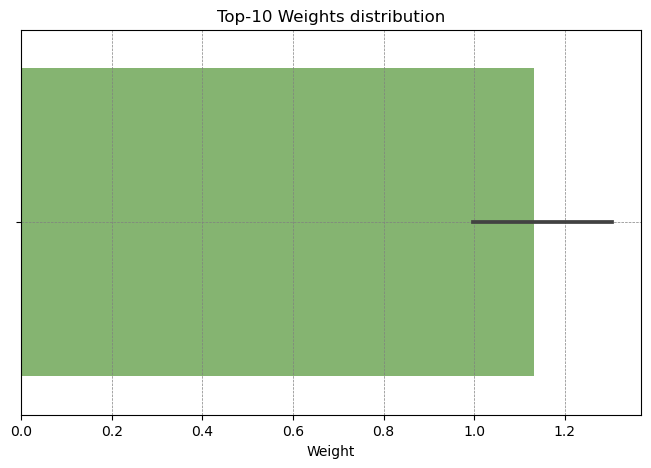

In [101]:
plt.figure(figsize = (8,5))
sns.barplot(coefs, x=0, palette = 'summer');

plt.title('Top-10 Weights distribution')
plt.xlabel('Weight')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5);

**Ответ:** Веса в среднем около 1.15, есть небольшой выброс, это вес у слова "crisis", в целом все слова часто используемы и справедливо находятся в топе.

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [102]:
print('Размерность итоговой таблицы:{}'.format(df.shape))
print('Размерность итоговой таблицы:{}'.format(df.UserName.shape))
print('Размерность итоговой таблицы:{}'.format(df.ScreenName.shape))

Размерность итоговой таблицы:(33444, 6)
Размерность итоговой таблицы:(33444,)
Размерность итоговой таблицы:(33444,)


**Ответ:** UserName и ScreenName все уникальны, закономерность выявить не представляется возможным, можно убрать их. Данные столбцы просто служат для идентификации объектов - условно индексация.

In [103]:
X_train.drop(['UserName', 'ScreenName'], axis = 1, inplace = True)
X_test.drop(['UserName', 'ScreenName'], axis = 1, inplace = True)

In [104]:
X_train.head()

,Location,TweetAt,OriginalTweet
25621,Unknown,06-04-2020,Why we still want to buy so much stuff during ...
30135,"Boston, MA HQ",10-04-2020,With driving even more usage a strong strategy...
28899,India,09-04-2020,@Canon_India I am very happy.. Great job by @C...
5989,"Mayfair, London, UK",19-03-2020,The U.S national debt will likely exceed $30 T...
4367,WNC,18-03-2020,"Finally got to the grocery store. Honestly, wh..."


Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на оспнове целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [105]:
X_test.TweetAt = pd.to_datetime(X_test.TweetAt, dayfirst=True)
X_train.TweetAt = pd.to_datetime(X_train.TweetAt, dayfirst=True)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23410 entries, 25621 to 2732
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Location       23410 non-null  object        
 1   TweetAt        23410 non-null  datetime64[ns]
 2   OriginalTweet  23410 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 731.6+ KB


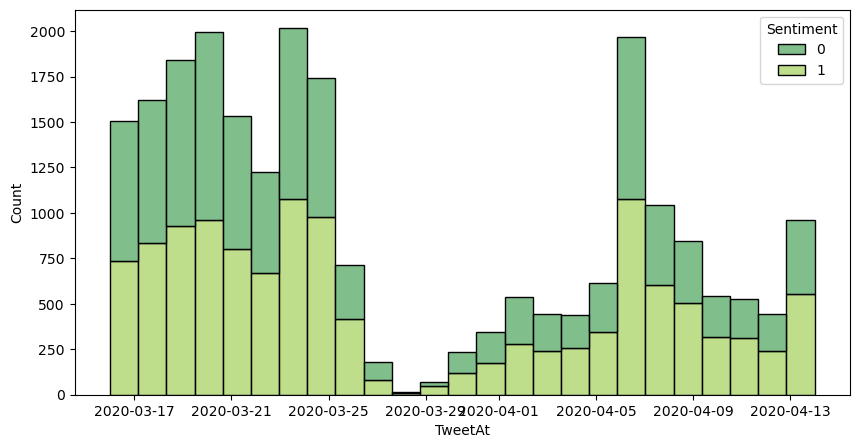

In [106]:
import seaborn as sns
plt.figure(figsize = (10,5))
sns.histplot(x=X_train['TweetAt'], hue = y_train, palette = 'summer', multiple = 'stack');

В каждую из дат распеределение твитов 1 или 0 примерно одинаково, более детально можно посмотреть соотношение в табличке sentiment_counts ниже. Сильно большой перевес в пользу положительных твитов был разве что 2020-03-28, но там было всего 16 твитов, что гораздо меньше обычного, медианное значение в день - 663.5 твитов

In [107]:
sentiment_counts = train.groupby(by = 'TweetAt')['Sentiment'].value_counts(normalize = True).unstack()
sentiment_counts.head() # здесь разбивка по тональности твитов на каждый день

Sentiment,0,1
TweetAt,,
01-04-2020,0.489914,0.510086
02-04-2020,0.484171,0.515829
03-04-2020,0.464126,0.535874
04-04-2020,0.417808,0.582192
05-04-2020,0.441368,0.558632


**Ответ:** Так как данные распределеным примерно одинаково каждый день, признак особо не имеет смысла, можно убрать

In [108]:
X_train.drop(['TweetAt'], axis = 1, inplace = True)
X_test.drop(['TweetAt'], axis = 1, inplace = True)

Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [109]:
X_train.Location.nunique() # уникальных значений

7949

In [110]:
X_train.Location.value_counts()

Unknown                           4944
London                             301
United States                      295
London, England                    274
New York, NY                       223
                                  ... 
Work: Kent and Live: Sussex          1
Somewhere on TradingView             1
Honolulu, Hawai?i                    1
SFO                                  1
Waterville, Ireland Austin, TX       1
Name: Location, Length: 7949, dtype: int64

Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

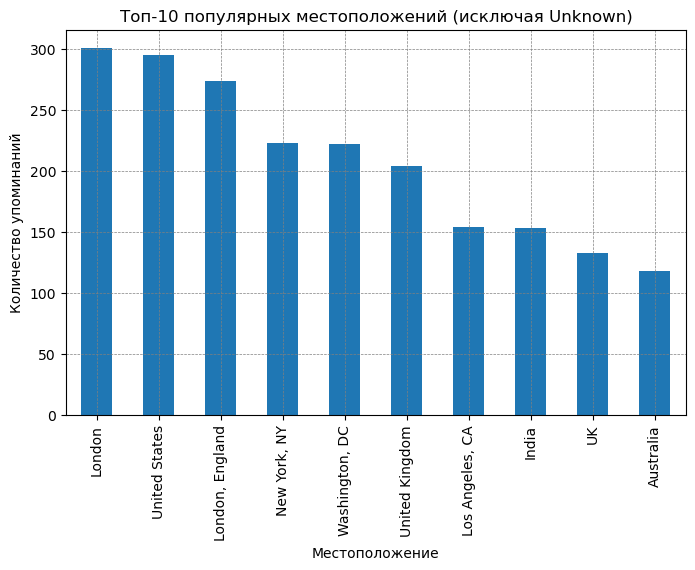

In [111]:
without_unknown = X_train[X_train.Location != "Unknown"]
top_locations = without_unknown.Location.value_counts().head(10)

plt.figure(figsize = (8,5))
top_locations.plot(kind = 'bar')

plt.title('Топ-10 популярных местоположений (исключая Unknown)')
plt.xlabel('Местоположение')
plt.ylabel('Количество упоминаний')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5);

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [112]:
def wider_location(table):
    locations = np.array(table.Location)
    split_fn = np.vectorize(lambda x: x.split(', ')[-1])
    split_locations = split_fn(locations).astype('str')
    split_locations = np.char.lower(split_locations)
    table['WiderLocation'] = split_locations
    return table

In [113]:
X_train=wider_location(X_train)

Посмотрим сколько уникальных значений в WiderLocation

In [114]:
X_train.WiderLocation.nunique()

4707

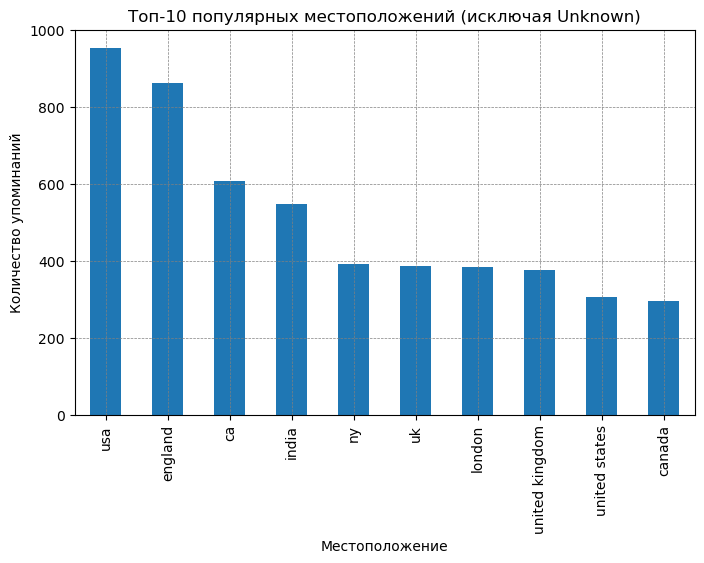

In [115]:
without_unknown = X_train[X_train.WiderLocation != "unknown"]
top_locations = without_unknown.WiderLocation.value_counts().head(10)

plt.figure(figsize = (8,5))
top_locations.plot(kind = 'bar')

plt.title('Топ-10 популярных местоположений (исключая Unknown)')
plt.xlabel('Местоположение')
plt.ylabel('Количество упоминаний')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5);

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?

In [116]:
location_counts = X_train.WiderLocation.value_counts()
frequent_locations = location_counts[location_counts > 1].index.values
frequent_locations.shape
# это количество всего

(988,)

In [117]:
# отфильтруем строки согласно условию выше

filtered_data = X_train[X_train.WiderLocation.isin(frequent_locations)]
filtered_data.head()

# дальше по этй штуке будем кодировать

,Location,OriginalTweet,WiderLocation
25621,Unknown,Why we still want to buy so much stuff during ...,unknown
28899,India,@Canon_India I am very happy.. Great job by @C...,india
5989,"Mayfair, London, UK",The U.S national debt will likely exceed $30 T...,uk
21350,"Ellicott City, MD",Friends: Catholic University's food service wo...,md
15378,Unknown,It's times like these you understand the value...,unknown


In [118]:
X_test = wider_location(X_test) # добавляю WiderLocation к X_test

In [119]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(categories='auto', handle_unknown='ignore')

ohe.fit(pd.DataFrame(filtered_data.WiderLocation))
encoded_location_train = ohe.transform(pd.DataFrame(X_train.WiderLocation))
encoded_location_test = ohe.transform(pd.DataFrame(X_test.WiderLocation))

Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [120]:
# # объединяю разреженные матрицы и закодированные ячейки
encoded_train = np.hstack((cv_df_bow_train.toarray(), encoded_location_train.toarray()))
encoded_test = np.hstack((cv_df_bow_test.toarray(), encoded_location_test.toarray()))
encoded_train.shape

(23410, 4688)

In [121]:
clf_6= LogisticRegression(max_iter=200, random_state=0)
clf_6.fit(encoded_train,y_train)
pred_6 = clf_6.predict(encoded_test)
pred_6

array([1, 0, 1, ..., 0, 1, 1])

In [122]:
print(classification_report(y_test, pred_6))

              precision    recall  f1-score   support

           0       0.83      0.82      0.83      4552
           1       0.86      0.86      0.86      5482

    accuracy                           0.85     10034
   macro avg       0.84      0.84      0.84     10034
weighted avg       0.85      0.85      0.85     10034



In [123]:
accuracy_6 = (y_test == pred_6).mean() # accuracy считаем
print(f'Accuracy после добавления нового признака Count Vectorizer: {accuracy_6}')
print(f'Accuracy после скалинга Count Vectorizer 3700: {accuracy_5}')
print(f'Изменение: {accuracy_6-accuracy_5}')

print(f'Accuracy после стемминга Count Vectorizer: {accuracy_3_cv}')
print(f'Accuracy Count Vectorizer: {accuracy_1_cv}')

Accuracy после добавления нового признака Count Vectorizer: 0.8452262308152282
Accuracy после скалинга Count Vectorizer 3700: 0.8446282639027307
Изменение: 0.0005979669124974718
Accuracy после стемминга Count Vectorizer: 0.8669523619693044
Accuracy Count Vectorizer: 0.8673510065776361


**Ответ:** Качество на тесте не изменилось практически в сравнении Accuracy после скалинга Count Vectorizer 3700. Но оно будет меняться при увеличении порога встречаемости для категорий при кодировке. Сейчас стоит 1 по условию

Лучший результат Accuracy был получен в самом начале домашки и составляет

In [124]:
print(f'Accuracy Count Vectorizer: {accuracy_1_cv}')

Accuracy Count Vectorizer: 0.8673510065776361


## Задание 8 Хорошее качество (Бонус 1 балл)

Добейтесь accuracy=0.9 на тестовой выборке (можно сменить токенайзер, векторайзер, модель и т.д.)